In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn import metrics
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from time import time
from collections import defaultdict
from wordcloud import WordCloud

In [22]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [23]:
# Load all 20 newsgroups categories
categories = [
    'alt.atheism',
    'comp.graphics',
    'comp.os.ms-windows.misc',
    'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware',
    'comp.windows.x',
    'misc.forsale',
    'rec.autos',
    'rec.motorcycles',
    'rec.sport.baseball',
    'rec.sport.hockey',
    'sci.crypt',
    'sci.electronics',
    'sci.med',
    'sci.space',
    'soc.religion.christian',
    'talk.politics.guns',
    'talk.politics.mideast',
    'talk.politics.misc',
    'talk.religion.misc'
]

print("Loading 20 newsgroups dataset for all categories...")
dataset = fetch_20newsgroups(subset='all', categories=categories,
                           shuffle=True, random_state=42,
                           remove=('headers', 'footers', 'quotes'))
true_k = len(categories)
print(f"Number of categories: {true_k}")

Loading 20 newsgroups dataset for all categories...
Number of categories: 20


In [25]:
sample_size = 5000
if len(dataset.data) > sample_size:
    print(f"Sampling {sample_size} documents for faster processing...")
    indices = np.random.choice(len(dataset.data), sample_size, replace=False)
    dataset.data = [dataset.data[i] for i in indices]
    dataset.target = dataset.target[indices]

In [26]:
# Perform Lemmatization
print("Performing lemmatization...")
lemmatizer = WordNetLemmatizer()
lemmatized_data = []
for doc in dataset.data:
    word_list = word_tokenize(doc)
    lemmatized_doc = " ".join([lemmatizer.lemmatize(word) for word in word_list])
    lemmatized_data.append(lemmatized_doc)
dataset.data = lemmatized_data

Performing lemmatization...


In [27]:
# TF-IDF Vectorization for K-means
print("Creating TF-IDF vectors...")
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode',
                                 stop_words='english',
                                 min_df=5, max_df=0.5,
                                 sublinear_tf=True)
X_tfidf = tfidf_vectorizer.fit_transform(dataset.data)
print(f"TF-IDF matrix shape: {X_tfidf.shape}")

Creating TF-IDF vectors...
TF-IDF matrix shape: (5000, 9034)


In [28]:
# Count Vectorization for LDA (faster than TF-IDF for LDA)
print("Creating Count vectors for LDA...")
count_vectorizer = CountVectorizer(strip_accents='unicode',
                                 stop_words='english',
                                 min_df=5, max_df=0.5)
X_counts = count_vectorizer.fit_transform(dataset.data)
print(f"Count matrix shape: {X_counts.shape}")

Creating Count vectors for LDA...
Count matrix shape: (5000, 9034)


In [29]:
# K-means Clustering
print("\nPerforming K-means clustering...")
km = MiniBatchKMeans(n_clusters=true_k, init='k-means++',
                    batch_size=1000, max_iter=100, n_init=3)
t0 = time()
km.fit(X_tfidf)
print(f"K-means clustering done in {time() - t0:.2f}s")


Performing K-means clustering...
K-means clustering done in 0.39s


In [31]:
# LDA Topic Modeling (optimized version)
print("\nPerforming LDA topic modeling...")
# Reduce vocabulary size for LDA to speed up
max_features = 2000
small_count_vectorizer = CountVectorizer(strip_accents='unicode',
                                       stop_words='english',
                                       max_features=max_features)
X_small_counts = small_count_vectorizer.fit_transform(dataset.data)

lda = LatentDirichletAllocation(n_components=true_k,
                               max_iter=20,
                               learning_method='online',
                               batch_size=128,
                               learning_offset=10.,
                               random_state=42,
                               n_jobs=-1)
t0 = time()
lda.fit(X_small_counts)
print(f"LDA done in {time() - t0:.2f}s")


Performing LDA topic modeling...
LDA done in 41.89s


In [33]:
# Assign LDA topics to documents
lda_topics = lda.transform(X_small_counts).argmax(axis=1)

def evaluate_clustering(true_labels, pred_labels):
    print("\nClustering Evaluation:")
    print(f"Homogeneity: {metrics.homogeneity_score(true_labels, pred_labels):.3f}")
    print(f"Completeness: {metrics.completeness_score(true_labels, pred_labels):.3f}")
    print(f"V-measure: {metrics.v_measure_score(true_labels, pred_labels):.3f}")
    print(f"Adjusted Rand-Index: {metrics.adjusted_rand_score(true_labels, pred_labels):.3f}")

print("\nK-means Evaluation:")
evaluate_clustering(dataset.target, km.labels_)

print("\nLDA Topic Evaluation:")
evaluate_clustering(dataset.target, lda_topics)


K-means Evaluation:

Clustering Evaluation:
Homogeneity: 0.016
Completeness: 0.058
V-measure: 0.025
Adjusted Rand-Index: 0.005

LDA Topic Evaluation:

Clustering Evaluation:
Homogeneity: 0.208
Completeness: 0.259
V-measure: 0.231
Adjusted Rand-Index: 0.089


In [34]:
# Visualization
def plot_clusters(X_embedded, labels, title, color_map=None):
    plt.figure(figsize=(12, 8))
    if color_map:

        scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
                              c=labels, alpha=0.6, cmap='tab20')
        # Create a legend with category names using the color_map and unique numerical labels
        handles = []
        legend_labels = []
        unique_labels = sorted(np.unique(labels))
        for label in unique_labels:
            handle = plt.scatter([], [], color=plt.cm.tab20(label), label=color_map[label])
            handles.append(handle)
            legend_labels.append(color_map[label])
        plt.legend(handles, legend_labels, title="Categories")
    else:
        plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
               c=labels, alpha=0.6, cmap='tab20')
    plt.title(title)
    plt.colorbar()
    plt.show()

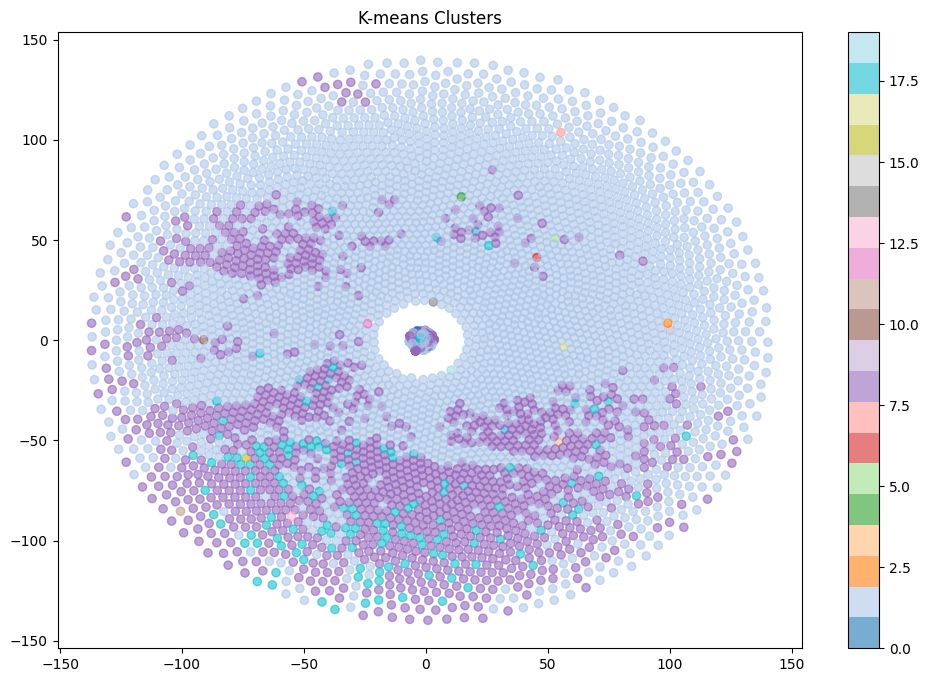

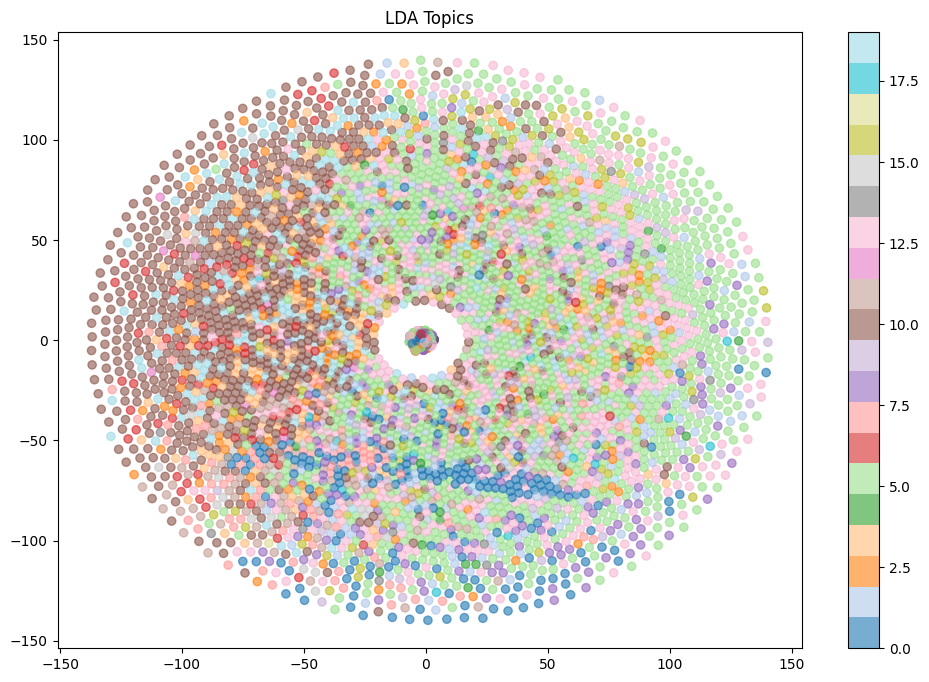

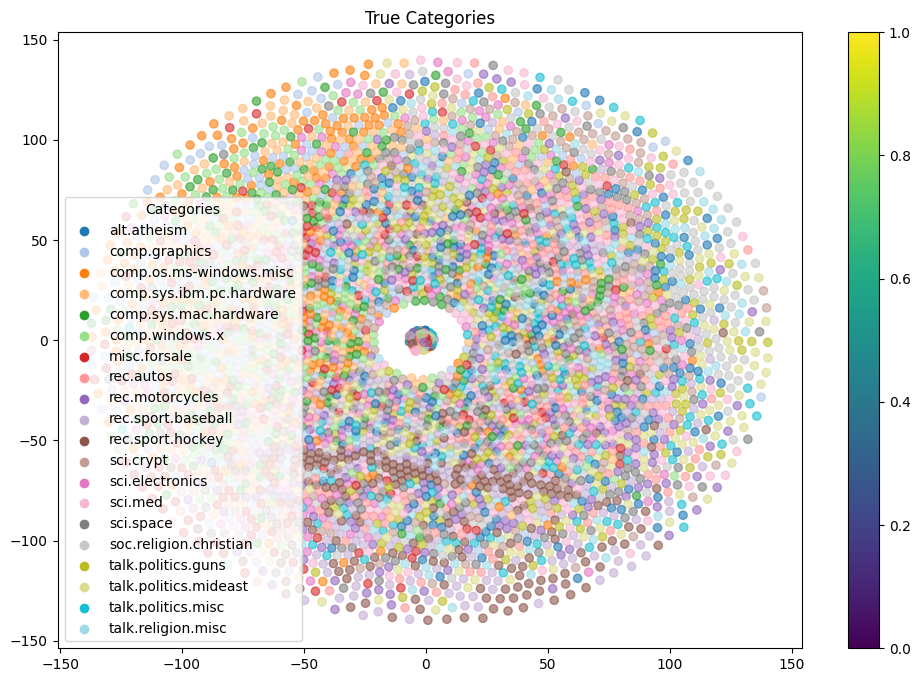

In [35]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_tfidf.toarray())

# Plot K-means clusters
plot_clusters(X_tsne, km.labels_, "K-means Clusters")

# Plot LDA topics
plot_clusters(X_tsne, lda_topics, "LDA Topics")

# Plot true categories
category_map = {i: cat for i, cat in enumerate(categories)}
plot_clusters(X_tsne, dataset.target, "True Categories", category_map)

In [36]:
def print_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                           for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("\nLDA Topics:")
print_topics(lda, small_count_vectorizer.get_feature_names_out())
results = pd.DataFrame({
    'Document': dataset.data,
    'True_Category': [categories[i] for i in dataset.target],
    'KMeans_Cluster': km.labels_,
    'LDA_Topic': lda_topics
})
results.to_csv('20newsgroups_clustering_results.csv', index=False)
print("\n\'20newsgroups_clustering_results.csv'")


LDA Topics:
Topic #0: game team year player hockey season wa play league new
Topic #1: israel question post point article evidence read jews wa ha
Topic #2: drive scsi ms cd hard cable circuit pin wiring bit
Topic #3: use program color bit entry output line code size section
Topic #4: mr right stephanopoulos government state people party political arm militia
Topic #5: people god say wa think like just doe know thing
Topic #6: image file edu jpeg format ftp gif available version site
Topic #7: edu 25 10 com 20 15 11 12 14 18
Topic #8: wa did said time day went child started going woman
Topic #9: law court gun property right atlantic case business weapon government
Topic #10: thanks card know dos mail like ha windows disk just
Topic #11: condition asking water university wire air box ground used center
Topic #12: monitor mode vga cpu clock oil chip unit bios tower
Topic #13: ha wa year know president think time going new just
Topic #14: space earth planet bike theory moon solar venus w

In [17]:
def predict_news_category(text):
    # Preprocess text
    words = [word.lower() for word in word_tokenize(text) if word.isalpha()]
    processed_text = " ".join([lemmatizer.lemmatize(word) for word in words])

    # Vectorize
    tfidf_vec = tfidf_vectorizer.transform([processed_text])
    count_vec = small_count_vectorizer.transform([processed_text])

    # Get cluster with similar documents
    cluster = km.predict(tfidf_vec)[0]
    distances = km.transform(tfidf_vec)[0]
    nearest_indices = np.argsort(distances)[:3]

    # Get dominant category in cluster
    cluster_mask = results['KMeans_Cluster'] == cluster
    top_categories = results[cluster_mask]['True_Category'].value_counts(normalize=True)
    predicted_category = top_categories.idxmax()
    confidence = top_categories.max()

    # Get LDA keywords
    topic_dist = lda.transform(count_vec)[0]
    top_topic = np.argmax(topic_dist)
    keywords = [small_count_vectorizer.get_feature_names_out()[i]
               for i in lda.components_[top_topic].argsort()[-10:][::-1]]

    # Get similar documents
    similar_docs = [results.iloc[idx]['Document'][:150] + "..."
                  for idx in nearest_indices]

    return {
        'category': predicted_category,
        'confidence': float(confidence),
        'keywords': keywords[:5],
        'cluster': int(cluster),
        'similar_docs': similar_docs
    }


sample = " Analysis of Pauline epistles in early Christianity"
prediction = predict_news_category(sample)

print("Predicted Category:", prediction['category'])
print("Confidence:", f"{prediction['confidence']:.0%}")
print("Keywords:", prediction['keywords'])
print("Cluster:", prediction['cluster'])
print("\nSimilar Documents:")
for i, doc in enumerate(prediction['similar_docs'], 1):
    print(f"{i}. {doc}")

Predicted Category: soc.religion.christian
Confidence: 6%
Keywords: ['people', 'ha', 'think', 'wa', 'question']
Cluster: 12

Similar Documents:
1. Hmmm ... what about the genocide conducted by the Ottoman Empire aganist the Armenians living in Turkey ....
2. Yes some radar detector are less detectable by radar detector detector . ; - )...
3. Ever since Craig Rowland posted his piece `` New Encryption '' to sci.crypt there ha been some discussion of our company , Secured Communications Tech...
